In [ ]:
import torch
from torchvision import datasets, transforms

from neural_blueprints.architectures.autoencoder import VariationalAutoEncoder
from neural_blueprints.config import AutoEncoderConfig, ConvLayerConfig, DenseLayerConfig, ReshapeLayerConfig, TrainerConfig
from neural_blueprints.utils import Trainer, get_device, image_plot

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
latent_dim = 20

vae_config = AutoEncoderConfig(
    encoder_layer_types=['conv2d', 'conv2d', 'flatten', 'dense', 'dense'],
    encoder_layer_configs=[
        ConvLayerConfig(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),    # 28x28 → 14x14
        ConvLayerConfig(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),   # 14x14 → 7x7
        {},                                                                                     # flatten
        DenseLayerConfig(input_dim=64*7*7, output_dim=512),                                     # 64 * 7 * 7 → 512
        DenseLayerConfig(input_dim=512, output_dim=latent_dim*2)                                # 512 → latent_dim * 2 (mean + logvar)
    ],
    decoder_layer_types=['dense', 'dense', 'reshape', 'conv2d_transpose', 'conv2d_transpose'],
    decoder_layer_configs=[
        DenseLayerConfig(input_dim=latent_dim, output_dim=512),                                                     # latent → 512
        DenseLayerConfig(input_dim=512, output_dim=64*7*7),                                                         # 512 → 64 * 7 * 7
        ReshapeLayerConfig(shape=(64,7,7)),                                                                         # reshape to (64,7,7)
        ConvLayerConfig(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),     # 7x7→14x14
        ConvLayerConfig(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1, activation='sigmoid')  # 14x14→28x28
    ]
)

model = VariationalAutoEncoder(vae_config)
model.blueprint()

VariationalAutoEncoder(
  (encoder): Encoder(
    (network): Sequential(
      (0): Conv2dLayer(
        (conv): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
        )
      )
      (1): Conv2dLayer(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
        )
      )
      (2): Flatten(start_dim=1, end_dim=-1)
      (3): DenseLayer(
        (linear): Linear(in_features=3136, out_features=512, bias=True)
        (normalization): Identity()
        (activation): Identity()
      )
      (4): DenseLayer(
        (linear): Linear(in_features=512, out_features=40, bias=True)
        (normalization): Identity()
        (activation): Identity()
      )
      (5): Identity()
    )
  )
  (decoder): Decoder(
    (network): Sequential(
      (0): DenseLayer(
        (linear): Linear(in_features=20, out_features=512, bias=True)
        (normalization

AttributeError: 'BaseModel' object has no attribute '__private_attributes__'

In [4]:
trainer = Trainer(
    config=TrainerConfig(
        learning_rate=1e-3,
        weight_decay=1e-5,
        save_weights_path="../models/vae_mnist.pth",
        batch_size=64,
        training_type="reconstruction",
        criterion="vae_loss",
        optimizer='adam'
    ),
    model=model
)
trainer.train(train_dataset=train_dataset, val_dataset=test_dataset, epochs=10)

Directory ../models already exists. Weights file may be overwritten.


Training Epochs:  10%|█         | 1/10 [00:23<03:29, 23.23s/epoch]

Epoch 1/10, Training Loss: 2480.9235, Validation Loss: 2066.1063


Training Epochs:  20%|██        | 2/10 [00:57<03:55, 29.48s/epoch]

Epoch 2/10, Training Loss: 2033.2775, Validation Loss: 1979.6182


Training Epochs:  30%|███       | 3/10 [01:37<04:00, 34.42s/epoch]

Epoch 3/10, Training Loss: 1980.6331, Validation Loss: 1943.1400


Training Epochs:  40%|████      | 4/10 [02:47<04:50, 48.34s/epoch]

Epoch 4/10, Training Loss: 1950.0616, Validation Loss: 1929.0828


Training Epochs:  50%|█████     | 5/10 [03:28<03:49, 45.82s/epoch]

Epoch 5/10, Training Loss: 1929.1843, Validation Loss: 1904.2680


Training Epochs:  60%|██████    | 6/10 [04:08<02:55, 43.99s/epoch]

Epoch 6/10, Training Loss: 1913.6401, Validation Loss: 1899.0346


Training Epochs:  70%|███████   | 7/10 [04:49<02:09, 43.02s/epoch]

Epoch 7/10, Training Loss: 1903.7913, Validation Loss: 1876.8952


Training Epochs:  80%|████████  | 8/10 [05:29<01:24, 42.08s/epoch]

Epoch 8/10, Training Loss: 1894.5834, Validation Loss: 1880.4458


Training Epochs:  90%|█████████ | 9/10 [06:10<00:41, 41.71s/epoch]

Epoch 9/10, Training Loss: 1885.5632, Validation Loss: 1881.4882


Training Epochs: 100%|██████████| 10/10 [06:52<00:00, 41.23s/epoch]


Epoch 10/10, Training Loss: 1880.1844, Validation Loss: 1865.6855


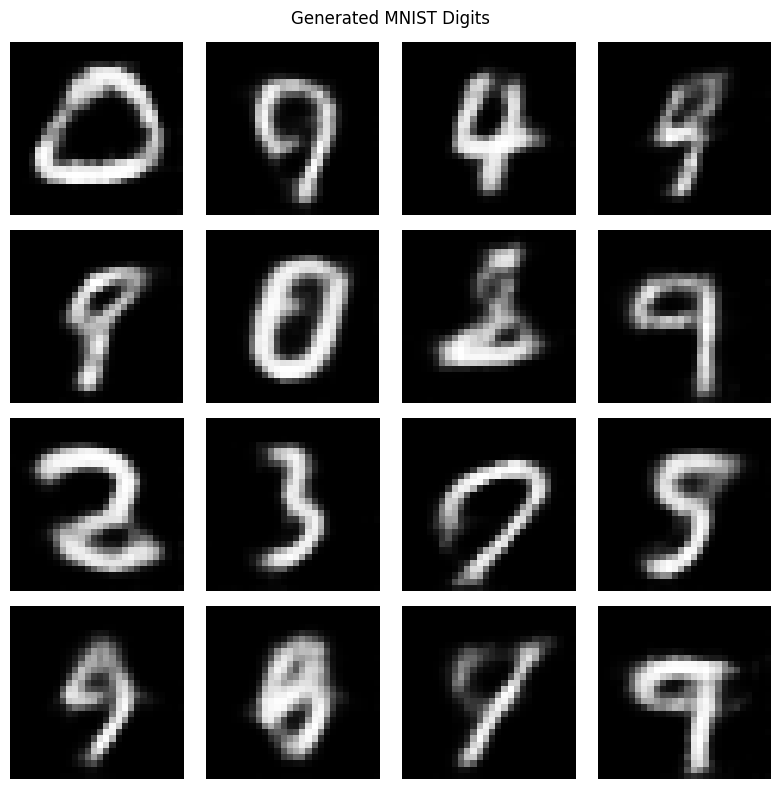

In [5]:
model.eval()
with torch.no_grad():
    samples = model.decode(torch.randn(16, latent_dim).to(get_device())).cpu()
    samples = samples.permute(0, 2, 3, 1)  # Convert from (N, C, H, W) to (N, H, W, C)

image_plot(images=samples, title="Generated MNIST Digits", cols=4)